In [118]:
# import libraries

import warnings
warnings.filterwarnings('ignore')

# general
import numpy as np
import pandas as pd

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# modeling
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, \
GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import r2_score, mean_absolute_error, \
mean_squared_error, mean_absolute_percentage_error

# tuning
from sklearn.model_selection import GridSearchCV

# feature engineering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display="diagram")
from kneed import KneeLocator

In [119]:
# load data
path = 'Data/all_grades_data_cleaned.csv'
df = pd.read_csv(path, index_col = 0)

In [120]:
# inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49975 entries, 0 to 50205
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   section_type       49975 non-null  object 
 1   instructor_id      49975 non-null  object 
 2   facility_code      46160 non-null  object 
 3   start_time         49975 non-null  float64
 4   mon                49975 non-null  bool   
 5   tues               49975 non-null  bool   
 6   wed                49975 non-null  bool   
 7   thurs              49975 non-null  bool   
 8   fri                49975 non-null  bool   
 9   sat                49975 non-null  bool   
 10  sun                49975 non-null  bool   
 11  subject_name       49975 non-null  object 
 12  course_name        49975 non-null  object 
 13  a_count            49975 non-null  int64  
 14  ab_count           49975 non-null  int64  
 15  b_count            49975 non-null  int64  
 16  bc_count           499

In [121]:
# drop columns not being used as target columns in this notebook
other_targets = ['a_count', 'ab_count', 'b_count', 'bc_count', 'c_count', 
                'd_count', 'f_count', 's_count', 'u_count', 'cr_count', 
                'n_count', 'p_count', 'i_count', 'nw_count', 'nr_count', 
                'other_count', 'a_proportion', 'ab_proportion', 
                'b_proportion', 'bc_proportion', 'c_proportion', 
                'd_proportion', 'f_proportion', 's_proportion', 
                'u_proportion', 'cr_proportion', 'n_proportion', 
                'p_proportion', 'i_proportion', 'nw_proportion', 
                'nr_proportion', 'other_proportion']
df.drop(columns = other_targets, inplace = True)

# check
df.columns

Index(['section_type', 'instructor_id', 'facility_code', 'start_time', 'mon',
       'tues', 'wed', 'thurs', 'fri', 'sat', 'sun', 'subject_name',
       'course_name', 'num_all_grades', 'avg_letter_grade', 'year', 'term',
       'class_length', 'course_difficulty'],
      dtype='object')

In [122]:
# convert 'year' to string, since it is really a categorical column
df['year'] = df['year'].astype(str)

In [123]:
# feature manipulation
# start_time

# start_time is given in minutes, so it is a numerical variable; courses
# without an assigned start_time are coded with -1
# start_time shouldn't be treated as a numeric variable since there is not a
# natural size order to times; for example, it's possible that courses in the
# afternoon give out higher grades than both courses in the mornings and
# evenings

# we will bin courses by start_time to morning, afternoon, evening, and none
# then we will be able to one-hot encode this variable

for index in df['start_time'].index:
    if df.at[index, 'start_time'] == -1:
        df.at[index, 'start_time'] = 'none'
    elif df.at[index, 'start_time'] < 720:
        df.at[index, 'start_time'] = 'morning'
    else:
        df.at[index, 'start_time'] = 'afternoon or evening'
        
# check
df['start_time'].value_counts()

afternoon or evening    24362
morning                 21693
none                     3920
Name: start_time, dtype: int64

In [124]:
# feature manipulation
# class_length

# bin into less than 75 and 75 or more
df['class_length'] = df['class_length'].apply(lambda x: 'shorter' 
                                             if x < 75 
                                             else 'longer')

# check
df['class_length'].value_counts()

longer     25813
shorter    24162
Name: class_length, dtype: int64

In [125]:
# feature manipulation
# num_all_grades

# small = under 15
# medium = 16-35
# large = over 35

# bin 
for index in df['num_all_grades'].index:
    if df.at[index, 'num_all_grades'] < 16:
        df.at[index, 'num_all_grades'] = 'small'
    elif df.at[index, 'num_all_grades'] < 36:
        df.at[index, 'num_all_grades'] = 'medium'
    else:
        df.at[index, 'num_all_grades'] = 'large'

# check
df['num_all_grades'].value_counts()

medium    20701
small     17024
large     12250
Name: num_all_grades, dtype: int64

In [126]:
# feature manipulation
# schedule

# first convert boolean values (True, False) to 1s and 0s so can be summed

days_in_week = ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun']

for day in days_in_week:
    df[day].replace({True: 1, False: 0}, inplace = True)

# check
df[['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun']]

,mon,tues,wed,thurs,fri,sat,sun
0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0
2,0,1,0,1,0,0,0
3,1,0,1,0,1,0,0
4,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...
50201,1,1,0,0,1,0,0
50202,1,1,0,0,1,0,0
50203,1,1,0,0,1,0,0
50204,1,1,0,0,1,0,0


In [127]:
# make new column
df['days_per_week'] = (df['mon'] + df['tues'] + df['wed'] +
                       df['thurs'] + df['fri'] + df['sat'] +
                       df['sun'])

# check
df[['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun', 'days_per_week']]

,mon,tues,wed,thurs,fri,sat,sun,days_per_week
0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,2
2,0,1,0,1,0,0,0,2
3,1,0,1,0,1,0,0,3
4,1,0,1,0,1,0,0,3
...,...,...,...,...,...,...,...,...
50201,1,1,0,0,1,0,0,3
50202,1,1,0,0,1,0,0,3
50203,1,1,0,0,1,0,0,3
50204,1,1,0,0,1,0,0,3


In [128]:
# change 1s and 0s to abbreviations

# change 1s and 0s in days of week columns to abbreviations 
# (M, T, W, R, F, A, U)

df['mon'].replace({1: 'M', 0: ''}, inplace = True)
df['tues'].replace({1: 'T', 0: ''}, inplace = True)
df['wed'].replace({1: 'W', 0: ''}, inplace = True)
df['thurs'].replace({1: 'R', 0: ''}, inplace = True)
df['fri'].replace({1: 'F', 0: ''}, inplace = True)
df['sat'].replace({1: 'A', 0: ''}, inplace = True)
df['sun'].replace({1: 'U', 0: ''}, inplace = True)

# check
df[['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun', 'days_per_week']]

,mon,tues,wed,thurs,fri,sat,sun,days_per_week
0,,,,,,,,0
1,,T,,R,,,,2
2,,T,,R,,,,2
3,M,,W,,F,,,3
4,M,,W,,F,,,3
...,...,...,...,...,...,...,...,...
50201,M,T,,,F,,,3
50202,M,T,,,F,,,3
50203,M,T,,,F,,,3
50204,M,T,,,F,,,3


In [129]:
# concatenate days of week columns into one
df['schedule_days'] = (df['mon'] + df['tues'] + df['wed'] + 
                       df['thurs'] + df['fri'] + df['sat'] + 
                       df['sun'])

# check
df['schedule_days'].value_counts()

TR         15477
MWF         9313
MW          7150
            3899
T           2485
W           2334
M           1985
MTWR        1816
R           1534
MTWRF       1240
F            893
MTRF         870
A            217
MF           206
WF           162
MWR           88
MTWF          69
U             40
MTR           31
TRF           31
TWRF          27
MR            22
FA            18
MT            14
WR            11
MWRF           9
MTF            7
MRF            5
TF             4
RF             4
MTW            3
TWR            3
TRA            2
WRF            2
TW             2
MA             1
MTWRFAU        1
Name: schedule_days, dtype: int64

In [130]:
# replace '' with 'none'
df['schedule_days'] = df['schedule_days'].apply(lambda x: 'none' 
                                                if x == '' 
                                                else x)

# check
df['schedule_days'].value_counts()

TR         15477
MWF         9313
MW          7150
none        3899
T           2485
W           2334
M           1985
MTWR        1816
R           1534
MTWRF       1240
F            893
MTRF         870
A            217
MF           206
WF           162
MWR           88
MTWF          69
U             40
MTR           31
TRF           31
TWRF          27
MR            22
FA            18
MT            14
WR            11
MWRF           9
MTF            7
MRF            5
TF             4
RF             4
MTW            3
TWR            3
TRA            2
WRF            2
TW             2
MA             1
MTWRFAU        1
Name: schedule_days, dtype: int64

In [131]:
# bin all schedules with fewer than 2500 values (5%) into 'other'

df['schedule_days'] = df['schedule_days'].apply(lambda x: x 
                                                if x in ['TR', 'MWF', 
                                                         'MW', 'none']
                                                else 'other')

# check
df['schedule_days'].value_counts()

TR       15477
other    14136
MWF       9313
MW        7150
none      3899
Name: schedule_days, dtype: int64

In [132]:
# drop original columns
df.drop(columns = ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun'], 
        inplace = True)

# check
df.columns

Index(['section_type', 'instructor_id', 'facility_code', 'start_time',
       'subject_name', 'course_name', 'num_all_grades', 'avg_letter_grade',
       'year', 'term', 'class_length', 'course_difficulty', 'days_per_week',
       'schedule_days'],
      dtype='object')

In [133]:
# drop categorical columns with high number of unique values
# and take away values in categorical columns that represent less than 5%
# (about 2500 rows)

cat_df = df.select_dtypes(include = 'object')

for col in cat_df.columns:
    print(col)
    print(df[col].value_counts())
    print()

section_type
lec    39610
lab     4852
sem     2603
ind     2055
fld      592
dis      263
Name: section_type, dtype: int64

instructor_id
other        44376
2601912.0      137
566960.0       132
496397.0       106
2601706.0       85
             ...  
631912.0        39
2600197.0       39
2600012.0       39
315329.0        39
3659559.0       38
Name: instructor_id, Length: 107, dtype: int64

facility_code
0482     7457
0469     4589
0140     3449
0408     2538
0545     2338
         ... 
0782        1
0092d       1
1400k       1
0033        1
0084b       1
Name: facility_code, Length: 120, dtype: int64

start_time
afternoon or evening    24362
morning                 21693
none                     3920
Name: start_time, dtype: int64

subject_name
spanish (spanish and portuguese)                 2965
english                                          2963
communication arts                               1905
art department                                   1779
mathematics               

In [134]:
# section type
df['section_type'] = df['section_type'].apply(lambda x: 'other' 
                                             if x in ['fld', 'dis']
                                             else x)

df['section_type'].value_counts()

lec      39610
lab       4852
sem       2603
ind       2055
other      855
Name: section_type, dtype: int64

In [135]:
# facility code
df['facility_code'] = df['facility_code'].apply(lambda x: 'other'
                                               if x not in ['0482', '0469', 
                                                            '0140', '0408']
                                               else x)

df['facility_code'].value_counts()

other    31942
0482      7457
0469      4589
0140      3449
0408      2538
Name: facility_code, dtype: int64

In [136]:
# subject name
df['subject_name'] = df['subject_name'].apply(lambda x: 'other'
                                             if x not in ['spanish (spanish and portuguese)', 'english']
                                             else x)

df['subject_name'].value_counts()

other                               44047
spanish (spanish and portuguese)     2965
english                              2963
Name: subject_name, dtype: int64

In [137]:
df.drop(columns = ['instructor_id', 'course_name'], inplace = True)

In [138]:
# check modified cat_cols

cat_df = df.select_dtypes(include = 'object')

for col in cat_df.columns:
    print(col)
    print(df[col].value_counts())
    print()

section_type
lec      39610
lab       4852
sem       2603
ind       2055
other      855
Name: section_type, dtype: int64

facility_code
other    31942
0482      7457
0469      4589
0140      3449
0408      2538
Name: facility_code, dtype: int64

start_time
afternoon or evening    24362
morning                 21693
none                     3920
Name: start_time, dtype: int64

subject_name
other                               44047
spanish (spanish and portuguese)     2965
english                              2963
Name: subject_name, dtype: int64

num_all_grades
medium    20701
small     17024
large     12250
Name: num_all_grades, dtype: int64

year
7     4769
8     4606
11    4583
10    4566
9     4561
14    4540
13    4515
15    4488
16    4431
17    4342
12    2321
18    2253
Name: year, dtype: int64

term
fall      28029
spring    21946
Name: term, dtype: int64

class_length
longer     25813
shorter    24162
Name: class_length, dtype: int64

course_difficulty
elementary      19888
in

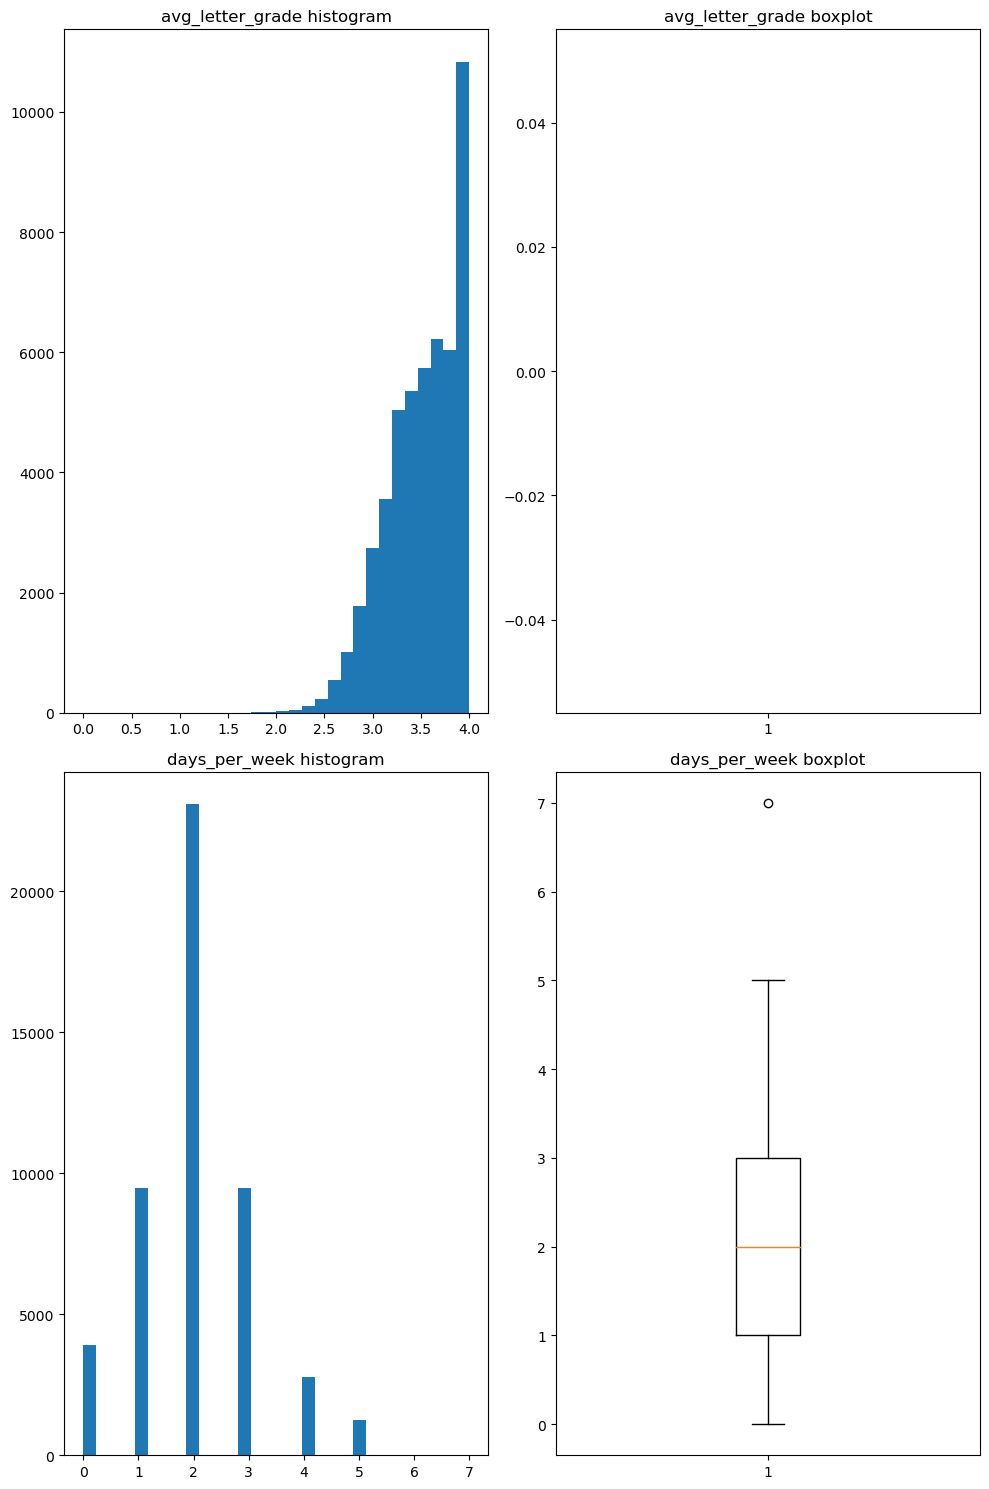

In [139]:
# take out outliers from numeric columns

num_df = df.select_dtypes(include = 'number')

fig, axes = plt.subplots(nrows = len(num_df.columns), 
                         ncols = 2, 
                         figsize = (10, 15))

for i, col in enumerate(num_df):

    axes[i][0].hist(df[col], bins = 30)
    axes[i][0].set_title(f"{col} histogram")
    
    axes[i][1].boxplot(df[col])
    axes[i][1].set_title(f"{col} boxplot")

plt.tight_layout()

In [140]:
len(df[df['days_per_week'] == 7])

1

In [141]:
df = df[df['days_per_week'] != 7]

In [142]:
df['days_per_week'].describe()

count    49974.000000
mean         2.030036
std          1.066570
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: days_per_week, dtype: float64

# Preprocessing

In [153]:
target = 'avg_letter_grade'
y = df[target]
X = df.drop(columns = target)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [144]:
df.duplicated().sum()

4272

In [145]:
df.drop_duplicates(inplace = True)

df.duplicated().sum()

0

In [146]:
df.isna().sum()

section_type           0
facility_code          0
start_time             0
subject_name           0
num_all_grades         0
avg_letter_grade     449
year                   0
term                   0
class_length           0
course_difficulty      0
days_per_week          0
schedule_days          0
dtype: int64

In [148]:
df.dropna(inplace = True)

df.isna().sum()

section_type         0
facility_code        0
start_time           0
subject_name         0
num_all_grades       0
avg_letter_grade     0
year                 0
term                 0
class_length         0
course_difficulty    0
days_per_week        0
schedule_days        0
dtype: int64

In [143]:
df.columns

Index(['section_type', 'facility_code', 'start_time', 'subject_name',
       'num_all_grades', 'avg_letter_grade', 'year', 'term', 'class_length',
       'course_difficulty', 'days_per_week', 'schedule_days'],
      dtype='object')

In [149]:
# ohe

ohe_cols = ['section_type', 'facility_code', 'start_time', 'subject_name',
           'num_all_grades', 'year', 'term', 'class_length', 
           'course_difficulty', 'schedule_days']

ohe = OneHotEncoder(handle_unknown = 'ignore',
                   sparse = False)

ohe_tuple = (ohe, ohe_cols)

In [150]:
# scale

scale_cols = ['days_per_week']

scaler = StandardScaler()

scale_tuple = (scaler, scale_cols)

In [152]:
preprocessor = make_column_transformer(ohe_tuple,
                                      scale_tuple,
                                      remainder = 'drop')

preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['section_type', 'facility_code', 'start_time',
                                  'subject_name', 'num_all_grades', 'year',
                                  'term', 'class_length', 'course_difficulty',
                                  'schedule_days']),
                                ('standardscaler', StandardScaler(),
                                 ['days_per_week'])])

# Modeling

In [110]:
# create dataframe to save evaluation metrics
regression_metrics_df = pd.DataFrame()

# check
regression_metrics_df.shape

(0, 0)

In [111]:
# define function that will print regression metrics 9for current model, and 
# store metrics in regression_metrics_df along with all other models' metrics
# for easy viewing

def evaluate_regression(model_pipe, X_train, X_test, y_train, y_test, name):
    
    # calculate predictions
    train_pred = model_pipe.predict(X_train)
    test_pred = model_pipe.predict(X_test)

    # store scores
    regression_metrics_df.at[name, 'Train R2'] = \
        r2_score(y_train, train_pred) 
    
    regression_metrics_df.at[name, 'Test R2'] = \
        r2_score(y_test, test_pred)
        
    regression_metrics_df.at[name, 'Train MAE'] = \
        mean_absolute_error(y_train, train_pred)
    
    regression_metrics_df.at[name, 'Test MAE'] = \
        mean_absolute_error(y_test, test_pred)
    
    regression_metrics_df.at[name, 'Train MAPE'] = \
        mean_absolute_percentage_error(y_train, train_pred)
    
    regression_metrics_df.at[name, 'Test MAPE'] = \
        mean_absolute_percentage_error(y_test, test_pred)
    
    regression_metrics_df.at[name, 'Train RMSE'] = \
        np.sqrt(mean_squared_error(y_train, train_pred))
    
    regression_metrics_df.at[name, 'Test RMSE'] = \
        np.sqrt(mean_squared_error(y_test, test_pred))
  
    # show scores for this model only (can call regression_metrics_df to 
    # see all scores)
    print(regression_metrics_df.loc[name, :])

In [ ]:
# baggingregressor
# kneighborsregressor
# randomforestregressor
# adaboost
# gradientboostingregressor
# votingregressor
# stackingregressor

In [155]:
%%time

# bagging regressor

def_br = BaggingRegressor(random_state = 42)

def_br_pipe = make_pipeline(preprocessor, def_br)

def_br_pipe.fit(X_train, y_train)

evaluate_regression(def_br_pipe, X_train, X_test, y_train, y_test, "Def BR")

Train R2      5.513131e-01
Test R2       2.900219e-01
Train MAE     1.828058e-01
Test MAE      2.403387e-01
Train MAPE    5.495974e-02
Test MAPE     1.451787e+12
Train RMSE    2.454937e-01
Test RMSE     3.126216e-01
Name: Def BR, dtype: float64
CPU times: total: 1.25 s
Wall time: 1.25 s


In [156]:
%%time

# kneighborsregressor

def_kn = KNeighborsRegressor()

def_kn_pipe = make_pipeline(preprocessor, def_kn)

def_kn_pipe.fit(X_train, y_train)

evaluate_regression(def_kn_pipe, X_train, X_test, y_train, y_test, "Def KNN")

Train R2      4.484587e-01
Test R2       2.763767e-01
Train MAE     2.092779e-01
Test MAE      2.438251e-01
Train MAPE    6.259437e-02
Test MAPE     1.474551e+12
Train RMSE    2.721810e-01
Test RMSE     3.156115e-01
Name: Def KNN, dtype: float64
CPU times: total: 14 s
Wall time: 1.29 s


In [157]:
%%time

# gradient boosting regressor

def_gbr = GradientBoostingRegressor()

def_gbr_pipe = make_pipeline(preprocessor, def_gbr)

def_gbr_pipe.fit(X_train, y_train)

evaluate_regression(def_gbr_pipe, X_train, X_test, y_train, y_test, "Def GBR")

Train R2      3.507822e-01
Test R2       3.597817e-01
Train MAE     2.321435e-01
Test MAE      2.336543e-01
Train MAPE    6.991335e-02
Test MAPE     1.479536e+12
Train RMSE    2.953003e-01
Test RMSE     2.968660e-01
Name: Def GBR, dtype: float64
CPU times: total: 3 s
Wall time: 3 s


In [158]:
%%time

# random forest regressor

def_rf = RandomForestRegressor()

def_rf_pipe = make_pipeline(preprocessor, def_rf)

def_rf_pipe.fit(X_train, y_train)

evaluate_regression(def_rf_pipe, X_train, X_test, y_train, y_test, "Def RF")

Train R2      5.631941e-01
Test R2       3.020225e-01
Train MAE     1.804271e-01
Test MAE      2.382008e-01
Train MAPE    5.428076e-02
Test MAPE     1.448511e+12
Train RMSE    2.422217e-01
Test RMSE     3.099682e-01
Name: Def RF, dtype: float64
CPU times: total: 8.66 s
Wall time: 8.65 s


All of these Test R2 scores so far are much lower than the Test R2 scores before dropping/combining all values from categorical columns representing less than 5% of data and dropping columns with many unique values. 